# Chapter 8
# Tree- Based Methods

Tree based methods involves stratifying or segmenting the predictor space into a no. of simple regions. To make a prediction, means or mode of training observations is used in the region it belongs.

Since the splitting rules can be summarized in a tree, these approches are called __decision tree methods.__

## Regression Trees
It consists of a series of splitting rules starting at the top of tree. For 2 variable $X_1$ and $X_2$(continous).

In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [3]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Hitters.csv"
Hitters = pd.read_csv(url)
Hitters = Hitters[Hitters["Salary"].isna() == False]
Hitters.shape

(263, 20)

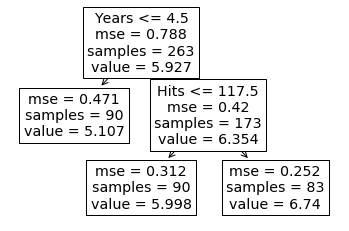

In [7]:
X = np.array(Hitters[["Years","Hits"]])
y = np.array(np.log(Hitters.Salary)).reshape(-1,1)
DT_model = DecisionTreeRegressor(random_state = 0, max_depth = 2, min_samples_leaf = 50).fit(X,y)
plot_tree(DT_model, feature_names = ["Years","Hits"])
plt.show()

Here, the tree has created 3 different segments.

$R_1$ = {X | Years <= 4.5}

$R_2$ = {X | Years > 4.5 and Hits <= 117.5}

$R_3$ = {X | Years > 4.5 and Hits > 117.5}

* These 3 regions are called the _terminal nodes_ or leaves of the tree.
* The point along the tree where the predictor space is split are called the _internal node_.
* Segments of the trees connecting the nodes are called _branches_.

The variable that is used for the split first is the most important variable and the importance decrease as we go down the tree.

Regression trees are the over- simplification of true relationship between X and y but they are easier to interpret and provides a nice graphical representation.

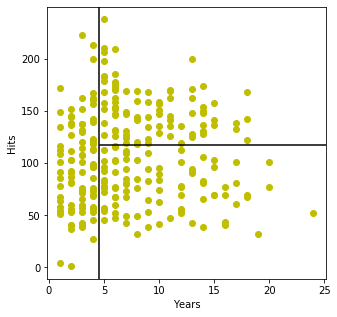

In [8]:
plt.figure(figsize = (5,5))
plt.scatter(Hitters.Years, Hitters.Hits, color = "y")
plt.axvline(x = 4.5, color = "black")
plt.axhline(y = 117.5, xmin = 0.19,color = "black")
plt.xlabel("Years"); plt.ylabel("Hits")
plt.show()

The above chart shows the 4 different region created by the decision tree above.

__Prediction and Stratification of feature space__
1. Divide the predictor space - i.e. the set of possible values for $X_1$, $X_2$ ,...., $X_p$ into J distinct and non-overlapping regions $R_1$, $R_2$,...,$R_J$.
2. For every observation that fall into regions $R_j$, we make same prediction (mean of the response value).

How to select the regions in step 1?

In theory, the regions could have any shape. However, we choose to divide into high dimensional rectangles. Goal is to find these boxes $R_1$, $R_2$,...,$R_J$ that minimizes the RSS given by 
$$\sum_{j = 1}^{J}\sum_{i\epsilon R_j}(y_i - \hat y_{R_j})^2$$
where $\hat y_{R_j}$ = mean response for training observations within $j^{th}$ box.

Considering all possible boxes is infeasible. We use greedy approach called __recursive binary splitting.__

It is greedy because at each step of tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some futher step.

__Recursive Binary Splitting__ :- Select $X_j$ and the cutpoint s such that splitting the predictor space into regions {X| $X_j$ < s} and {X| $X_j \ge$ s} leads to greatest rejection in RSS.

For any j and s, we define the pair of half planes as 
$$R_1(j,s) = {X| X_j < s}\ \ and\ \ R_2(j,s) = {X| X_j \ge s}$$
and we seek the value of j and s that minimizes the equation
$$\sum_{i:x_i\epsilon R_1(j,s)}(y_i - \hat y_{R_1})^2 + \sum_{i:x_i\epsilon R_2(j,s)}(y_i - \hat y_{R_2})^2$$
where $\hat y_{R_1}$ is the mean response for the training observations in $R_1(j,s)$ and $\hat y_{R_2}$ is mean response for $R_2(j,s)$.

Then, we repeat the same process but in one of these 2 regions instead of the original predictor space. The process continues until a stopping criteria is reached.

Once the region $R_1$,...,$R_J$ have been created, we perdict the response for a given test observation using the mean of training observation from that region.

__Tree Pruning__ :- If we let the tree grow without restriction, it will become too complex and overfit the data.
* Build tree only so long as the decrease in the RSS due to each split exceeds some threshold. Disadvantage of this method is that we might miss a good split that has about to come after few splits.
* Another method is to grow a very large tree $T_o$ and then prune it back to a subtree.

Our goal is to select a subtree that leads to the lowest test error rate (we can use cross  validation) but CV for each possible subtree would be too cumbersome. To overcome that, we use Cost Complexity pruning (also called the weakest link pruning).

__Cost Complexity Pruning__ :- Rather than considering every subtree, consider a sequence of trees indexed by a non-negative tuning parameter $\alpha$. For each value of $\alpha$ there corresponds a subtree $T \subset T_o$ such that
$$\sum_{m = 1}^{|T|} \sum_{i:x_i\epsilon R_m}(y_i - \hat y_{R_m})^2 + \alpha |T|$$ is as small as possible.

|T| = no. of terminal nodes.

$R_m$ = rectangle corresponding to $m^{th}$ terminal nodes.

$\alpha$ = controls the trade off between the subtree's complexity and its fit to the training data. If $\alpha$ = 0, then the subtree T will simply equal to $T_o$. As $\alpha$ increase, tree gets shorter.

__Steps to build a regression tree__:-
1. Use recursive binary splitting to grow a large tree on training data, stopping only when each terminal node has fewer than some minimum number of observation.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtree, as a function of $\alpha$.
3. Use k-fold cross validation to choose $\alpha$.
4. Return the subtree from Step 2 that corresponds to the choosen tree.

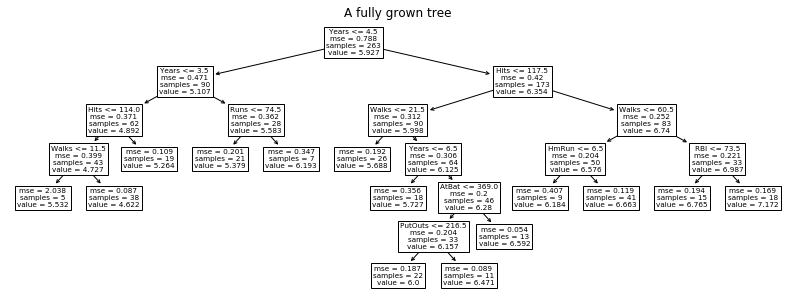

In [65]:
columns = Hitters.select_dtypes(exclude = "object").drop("Salary", axis = 1).columns
var_list_rm_C = [x for x in columns if re.search('^C', x) is None]
X = np.array(Hitters[var_list_rm_C])
y = np.array(np.log(Hitters.Salary)).reshape(-1,1)
DT_model = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 5, min_impurity_decrease = 0.005).fit(X,y)
plt.figure(figsize = (14,5))
plot_tree(DT_model, feature_names = var_list_rm_C)
plt.title("A fully grown tree")
plt.show()

## Classification Trees
To predict a qualitative response.
* We predict that each observation belongs to the most commonly occuring class of training observations in the region to which it belongs.
* We also calculate class proportions among training observations that falls in that regions.
* Instead of using RSS as a criterion for making the binary splits, a natural alternative to RSS is classification error rate(fraction of training observations in that region that do not belongs to most comkon class).
$$E = 1 - max_K(\hat p_{mk})$$
$\hat p_{mk}$ = proportion of training observation in $m^{th}$ region that are from the $k^{th}$ class.

Classification error is not suficiently sensitive for tree growing. Gini Index $$G = \sum_{k = 1}^{K} \hat p_{mk} (1- \hat p_{mk})$$
This is the measure of total varaince across the K classes.

If $\hat p_{mk}$ are close to zero or one, Gini takes on a small value (also called measure of node purity). Small value indicates that a node contains predominantly observation from a single class.

Another alternative is entropy $$D = -\sum_{k=1}^{K}\hat p_{mk}log\hat p_{mk},\ \ \ 0\le -\hat p_{mk}log\hat p_{mk}$$
Entropy take a value near 0 if $\hat p_{mk}$ are all near 0 or near 1.

Gini or entropy can be used to evaluate the quality of a particular split. Classification error rate is preferable if prediction accuracy of the final prune tree is the goal.